# Dynamic Programming Approach for Single asset

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)

    return [mean,cov_matrix]


n = 1
regimes = []
N = 2
T= 50
rf = 0.0154/50
gamma = -1
tpm = np.array([[0.981,0.019],[0.047,0.953]])
regimes = [[[0.00312],[[0.00022]]],[[-0.00175],[[0.00116]]]]

def generate_scenario(prob,t):
    current_regime = np.random.choice(N,p = prob)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_regime = np.random.choice(range(N))
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_regime = np.random.choice(range(N), p = tpm[curr_regime])
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        returns = np.array(returns)
        sample.append([curr_regime,returns])

    return sample


generate_monte_carlo_sample()

[[1, [0.016895254446052575, 0.000308]],
 [1, array([0.0003967, 0.000308 ])],
 [1, array([-0.02719728,  0.000308  ])],
 [1, array([-0.04433015,  0.000308  ])],
 [1, array([0.00786953, 0.000308  ])],
 [1, array([0.04600472, 0.000308  ])],
 [0, array([0.0125583, 0.000308 ])],
 [0, array([-0.0169421,  0.000308 ])],
 [0, array([0.03499199, 0.000308  ])],
 [0, array([0.01839231, 0.000308  ])],
 [0, array([0.00620441, 0.000308  ])],
 [0, array([0.0153194, 0.000308 ])],
 [0, array([-0.01041823,  0.000308  ])],
 [0, array([0.0126089, 0.000308 ])],
 [1, array([-0.02226973,  0.000308  ])],
 [1, array([-0.052128,  0.000308])],
 [1, array([0.00882563, 0.000308  ])],
 [1, array([0.03259286, 0.000308  ])],
 [1, array([0.03233749, 0.000308  ])],
 [1, array([0.05860924, 0.000308  ])],
 [1, array([-0.00246903,  0.000308  ])],
 [1, array([0.02950264, 0.000308  ])],
 [1, array([0.02847514, 0.000308  ])],
 [1, array([0.02823885, 0.000308  ])],
 [1, array([-0.0598599,  0.000308 ])],
 [1, array([0.01178552, 

In [2]:
generate_scenario([1,0],0)

array([0.02753074, 0.000308  ])

In [3]:
print(regimes[1][:])

[[-0.00175], [[0.00116]]]


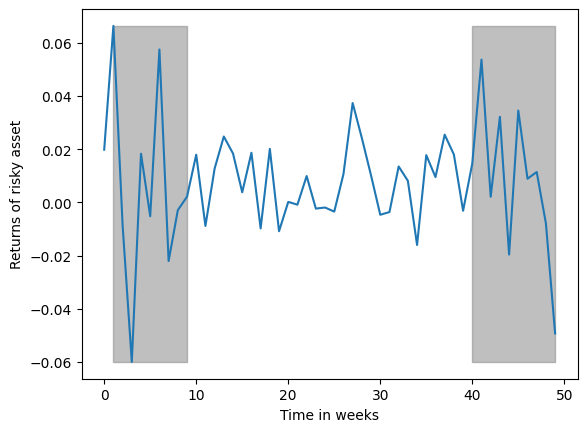

In [25]:
sample_returns = generate_monte_carlo_sample()
import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
flig,ax = plt.subplots()
ax.plot(x_values,y_values)
ax.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.5)
plt.xlabel("Time in weeks")
plt.ylabel("Returns of risky asset")
plt.show()

## Probabilty set initialization over different regimes

In [109]:
from itertools import product
from scipy.optimize import minimize

discrete_prob = 50
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [110]:
delta_pi = 0.02
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [111]:
print(possible_pi[-1])

[ 1.00000000e+00 -1.11022302e-15]


In [112]:
def closest_probability_distn(p_in):
    lowest_norm = np.array(float('inf'))
    ind = 0

    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array)
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    r = r[:-1]
    density = np.array([multivariate_normal.pdf(r,mean = regimes[i][0], cov = regimes[i][1]) for i in range(N)])
    p_new = tpm.T@(density*p)
    p_new/=np.sum(p_new)
    
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
  return np.sum(pi*(1+r))

# Dynamic Programming Algorithm

In [113]:
T = 5
V = {}
for _ in range(len(possible_probabities)):
    V[(_,T)] = (1**gamma)/gamma


t = T-1
M = 20000
pi_l = -1.0
pi_u = 1.0


optimal_pi_star = {}

# scenarios = []_star = {}
for iter in range(1):
    # scenarios = []
    # for j in range(M):
    #     sample = generate_monte_carlo_sample()
    #     scenarios.append(sample)
    # print("Samples generated")
    t = T-1
    while (t>=0):
        # returns_at_this_time = [scenarios[i][t][1] for i in range(M)]
        #print(returns_at_this_time)
        for _ in range(len(possible_probabities)):
            returns_at_this_time = []
            updateBelief_saved = np.zeros(M)
            for j in range(M):
                sample = generate_scenario(possible_probabities[_],t)
                returns_at_this_time.append(sample)
                updateBelief_saved[j] = updateBelief(sample,possible_probabities[_])[1]

            # print(updateBelief_saved)
            def objective_function(pi):
                return np.average(np.array([(newWealth(returns_at_this_time[i],pi)**gamma)*V[(updateBelief_saved[i],t+1)] for i in range(M)]))

            # constraints = ([{'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1}])  
            # initial_pi_guess = np.ones(n+1)/(n+1)
            # if(_):
            #     initial_pi_guess = optimal_pi_star[(_-1,t)]
            

            # pi_star = minimize(lambda x: (-1)*objective_function(x),  initial_pi_guess,
            #                    constraints=constraints,
            #                     bounds = [(pi_l,pi_u) for i in range(n)] + [(None,None)],
            #                   )

            # print(pi_star.message)
            # pi_star = pi_star.x


            pi_star = max(possible_pi,key = objective_function)
            
            V[(_,t)] = np.average([(newWealth(returns_at_this_time[i],pi_star)**gamma)*V[(updateBelief_saved[i],t+1)] for i in range(M)])
            optimal_pi_star[(_,t)] = pi_star
            print(iter,t,possible_probabities[_],pi_star)

        t= t-1
        print("\n")



0 4 [0. 1.] [-0.92  1.92]
0 4 [0.02 0.98] [-1  2]
0 4 [0.04 0.96] [-0.96  1.96]
0 4 [0.06 0.94] [-0.8  1.8]
0 4 [0.08 0.92] [-0.66  1.66]
0 4 [0.1 0.9] [-0.48  1.48]
0 4 [0.12 0.88] [-0.84  1.84]
0 4 [0.14 0.86] [-0.74  1.74]
0 4 [0.16 0.84] [-0.54  1.54]
0 4 [0.18 0.82] [-0.88  1.88]
0 4 [0.2 0.8] [-0.5  1.5]
0 4 [0.22 0.78] [-0.62  1.62]
0 4 [0.24 0.76] [-0.56  1.56]
0 4 [0.26 0.74] [-0.38  1.38]
0 4 [0.28 0.72] [-0.52  1.52]
0 4 [0.3 0.7] [-0.4  1.4]
0 4 [0.32 0.68] [-0.1  1.1]
0 4 [0.34 0.66] [-0.34  1.34]
0 4 [0.36 0.64] [-0.28  1.28]
0 4 [0.38 0.62] [-0.1  1.1]
0 4 [0.4 0.6] [6.17561557e-16 1.00000000e+00]
0 4 [0.42 0.58] [-0.02  1.02]
0 4 [0.44 0.56] [0.04 0.96]
0 4 [0.46 0.54] [6.17561557e-16 1.00000000e+00]
0 4 [0.48 0.52] [0.04 0.96]
0 4 [0.5 0.5] [0.14 0.86]
0 4 [0.52 0.48] [0.18 0.82]
0 4 [0.54 0.46] [0.52 0.48]
0 4 [0.56 0.44] [0.68 0.32]
0 4 [0.58 0.42] [0.7 0.3]
0 4 [0.6 0.4] [0.72 0.28]
0 4 [0.62 0.38] [0.72 0.28]
0 4 [0.64 0.36] [ 1.00000000e+00 -1.11022302e-15]
0 4 [0

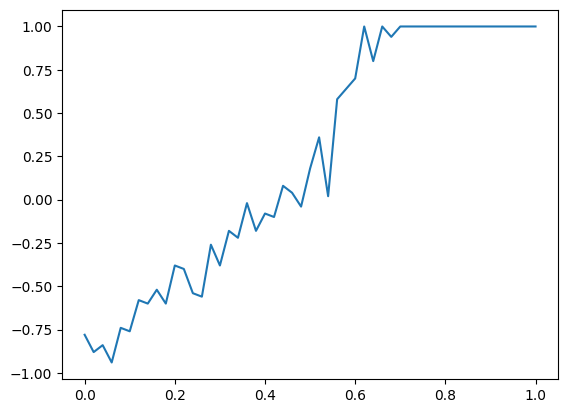

In [114]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.show()

#print([optimal_pi_star[_,0] for _ in range(5)])

In [115]:
import pickle


with open("Example1_DP_V_values.pkl", "wb") as fp:
    pickle.dump(V, fp)  

with open("Example1_DP_optimal_allocation.pkl", "wb") as fp:
    pickle.dump(optimal_pi_star, fp)  